In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab04.ipynb")

# Lab 4:  Sampling from unknown distributions

Welcome to the 4th Data 102 lab! 

The goal of this Lab is to get you familiar with 3 sampling strategies for obtaining samples from unknown distributions:
 - Rejection Sampling
 - Gibbs Sampling
 - Metropolis Hastings
 
The Lab looks long because we are trying to cover a lot of ground. However there is relatively little code you need to write. The only 'bigish' function you need to write is **2.a**. The code and responses you need to fill in are represented by `...`. There is additional documentation for each part as you go along. 

##### Please read carefully the introduction and the instructions to each problem.

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Collaborators**: 

## Submission
See the [Gradescope Submission Guidelines](https://edstem.org/us/courses/33922/discussion/2419862) for details on how to submit your lab.

Again, since this lab involves sampling, **tests may take awhile to run. Please submit as early as possible, as last minute submissions may overwhelm datahub, preventing yourself and others from submitting on-time.**

**For full credit, this assignment should be completed and submitted before Friday, February 24th, 2023 at 11:59 PM PST.**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal, norm, uniform
from ipywidgets import interact, interactive

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import hashlib
  
sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()


## Setup

In this Lab you are given a two dimensional unnormalized density function $q(x,y)$ represented by `target_density` below. The goal of the 3 questions in this lab is to build up a sampler that can output samples from the distribution proportional to $q(x,y)$. 

In **Question 1** we will compute samples via *Rejection Sampling*. In part **1.a** we will build a sampler for a 1-dimensional projection of the density. In part **1.b** we will extend the approach to two dimensions.

In **Question 2** we will compute samples via *Gibbs Sampling*. We will use the 1-D rejection sampler as a subroutine.

In **Question 3** we will compute samples via *Metropolis-Hastings*. 

Finally we will compare the above methods.

*Throughout this lab we will assume that our computers have access only to normal and uniform random variables.*

In [3]:
# This is the target unnormalized density from which we would like to sample
# Run this to define the function
# No TODOs here
@np.vectorize # <- decorator, makes function run faster
def target_density(x, y):
    mean1 = [1, 1.7]
    mean2 = [2, 1.3]
    mean3 = [1.5, 1.5]
    mean4 = [2, 2.1]
    mean5 = [1, 1.2]
    cov1=0.2*np.array([[0.2, -0.05], [-0.05, 0.1]])
    cov2 = 0.3*np.array([[0.1, 0.07], [0.07, 0.2]])
    cov3= np.array([[0.1, 0], [0, 0.1]])
    cov4 = 0.1*np.array([[0.3, 0.04], [0.04, 0.2]])
    cov5 = 0.1*np.array([[0.4, -0.04], [-0.04, 0.2]])
    return(multivariate_normal.pdf([x, y], mean=mean1, cov=cov1) + 
           multivariate_normal.pdf([x, y], mean=mean2, cov=cov2) +
           2*multivariate_normal.pdf([x, y], mean=mean3, cov=cov3) +
           0.5*multivariate_normal.pdf([x, y], mean=mean4, cov=cov4)+
           0.5*multivariate_normal.pdf([x, y], mean=mean5, cov=cov5))

#### Let's visualize this density. 

Run the cell below to see a 3D plot of the function along with a contour plot.

In [4]:
# No TODOs here, just run the cell to make plots
# Create a meshgrid of coordinates
coords = np.arange(0.5, 2.5, 0.02)
X, Y = np.meshgrid(coords, coords)

# Compute the value of the target density at all pairs of (x,y) values
Z = target_density(X,Y)

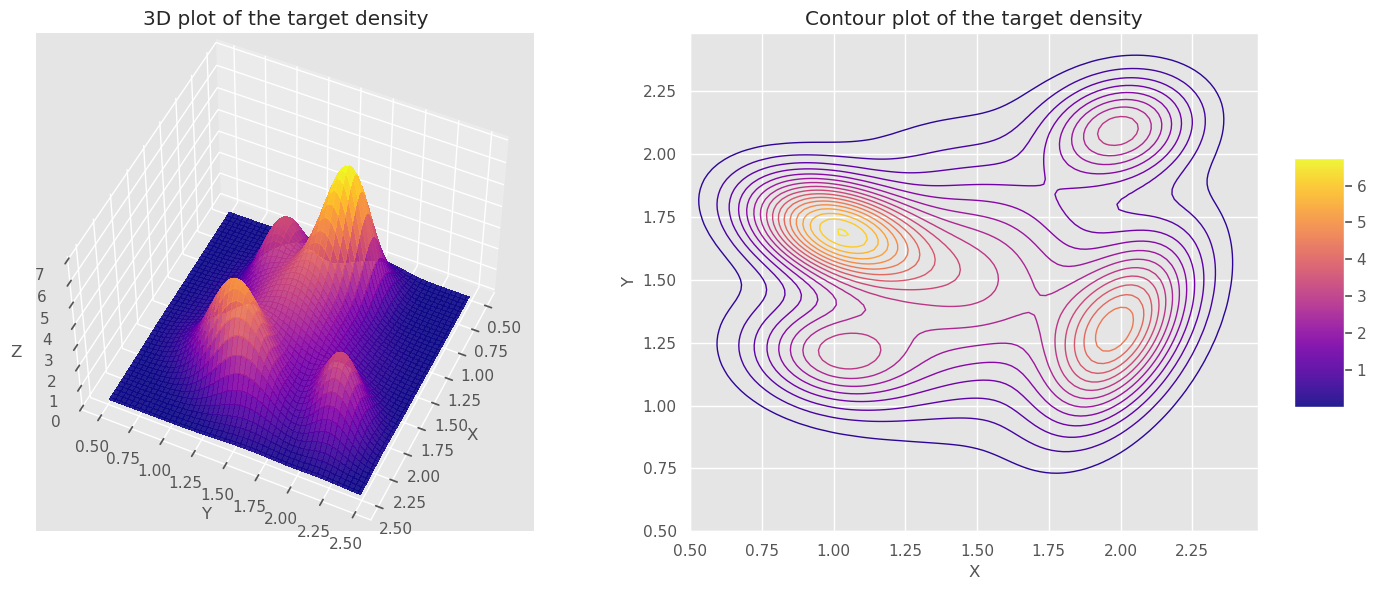

In [5]:
# Display the 3D plot of the target density
fig = plt.figure(figsize=(15,6))

ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122)

surf = ax0.plot_surface(X,Y,Z, cmap=cm.plasma, linewidth=0, antialiased=False,alpha = 0.9,)

# Customize the z axis.
ax0.set_zlim(0, 7)
ax0.set_xlabel("X")
ax0.set_ylabel("Y")
ax0.set_zlabel("Z")
ax0.set_title("3D plot of the target density")

# Rotate the axes: you can change these numbers in order to see the distribution from other angles
ax0.view_init(50, 25)

# Plot the contour plot of the density
cont = ax1.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_title("Contour plot of the target density")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax1)
plt.tight_layout()
plt.show()

Take a moment to examine the plots. Make sure you can see correspondances between each peak in the 3D plot on the left; and the "high-altitude" regions in the countour plot on the right.

Next we will plot 1-dimensional projections of the target densities onto the $X$ and $Y$ axis. These correspond to conditional target distributions of the form $q(x, y=y')$ and $q(x=x', y)$.

In [6]:
# Do not modify
# Run the cell below to define the plotting functions

COORDINATES = np.arange(0, 3, 0.02)
def plot_x_cond(y_val):
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    axs[0].contour(X,Y,Z, levels = 20, cmap=cm.plasma, alpha = 0.8, linewidths=0.8)
    axs[0].axhline(y_val,  ls="--", color = 'olive', lw = 2)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title("Contour plot of the target density")
    
    axs[1].plot(COORDINATES, target_density(COORDINATES, y_val), color = 'olive')
    axs[1].set_ylim(0,10)
    axs[1].set_xlim(0,3)
    axs[1].set_xlabel("X")
    axs[1].set_title("Conditional target density: q(x | y={:.1f})".format(y_val))
    plt.show()
    
def plot_y_cond(x_val):
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    axs[0].contour(X,Y,Z, levels = 20, cmap=cm.plasma, alpha = 0.8, linewidths=0.8)
    axs[0].axvline(x_val,  ls="--", color = 'olive', lw = 2)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title("Contour plot of the target density")
    
    axs[1].plot(COORDINATES, target_density(x_val, COORDINATES), color = 'olive')
    axs[1].set_ylim(0,10)
    axs[1].set_xlim(0,3)
    axs[1].set_xlabel("Y")
    axs[1].set_title("Conditional target density: q(y | x={:.1f})".format(x_val))
    plt.show()

In [7]:
# Display interactive plot
interactive_plot = interactive(plot_x_cond, y_val=(0, 3, 0.1), add_proposal=False)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='y_val', max=3.0), Output()), _dom_classes=('widget-i…

Set different values of `y_val`, observe the changes in the conditional target density.

In [8]:
# Display interactive plot
interactive_plot = interactive(plot_y_cond, x_val=(0, 3, 0.1), add_proposal=False)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x_val', max=3.0), Output()), _dom_classes=('widget-i…

Set different values of `x_val`, observe the changes in the conditional target density.

<!-- BEGIN QUESTION -->

### A Quick Understanding Check:

We said that $q$ is an unnormalized density function. What does this mean? How could we test whether or not the function is normalized?

Unnormalized density function means that its total probability does not equal to 1. To test whether they are normalized or not, we can set an integral equal to 1.

<!-- END QUESTION -->

## Question 1. Rejection Sampling

In this question, we will build a rejection sampler. First, let's review the basics. 

Assume we want to sample from an unnormalized target density $q(x)$, using a proposal distribution $F$, with density $f(x)$. The proposal distribution is chosen such that we have access to samples from it. 

#### Rejection sampling proceeds as follows:

- Find constant $c$, such that $cq(x)\leq f(x)$ on the support
- At each iteration:
    - Sample $x_i \sim F$
    - Compute the ratio $r = \frac{c(q(x_i))}{f(x_i)} \leq 1$
    - Sample $\gamma_i \sim Uniform(0,1)$:
        - `accept` the sample if $\gamma_i \leq r$: Add $x_i$ to the list of samples.
        - `reject` the sample otherwise: do nothing
        
### 1.a Sample from the one-dimensional density $q(x, y=1.2)$
Throughout part 1.a, we will restrict our attention to the range $[0,3]$ for simplicity. That way we can use Uniform(0,3) as our proposal distribution. Meaning that $f(x) = \frac{1}{3} \ \forall x\in[0,3]$.

In [9]:
# Create the target 1D density q(x, y = 1.2)
def target_1D_density(x):
    return(target_density(x, 1.2))

Finish implementing the steps of the rejection sampling algorithm by filling in the following code.

*Hint: both scipy and numpy provide methods for drawing from a uniform distribution.*

In [10]:
def sample_1D_proposed_distribution(N):
    """ 
    Produces N samples from the Uniform(0,3) proposal distribution
    
    Inputs:
        N : int, desired number of samples
        
    Outputs:
        proposed_samples : an 1d-array of size N which contains N independent samples from the proposal
    """
    return np.random.uniform(0, 3, N)

@np.vectorize
def compute_ratio_1D(proposed_sample, c):
    """
    Computes the ratio between the scaled target density and proposal density evaluated at the 
    proposed sample point
    
    Inputs:
        proposed_sample : float, proposed sample
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        ratio : float
    """
    return (c * target_1D_density(proposed_sample)) / (1/3)

@np.vectorize
def accept_proposal(ratio):
    """ 
    Accepts or rejects a proposal with probability equal to ratio
    
    Inputs: 
        ratio: float, probability of acceptance
    
    Outputs:
        accept: True/False, if True, accept the proposal
    """
    return np.random.uniform(0, 1) < ratio

You can use the following cell to test your functions to convince yourself that they work. 

In [11]:
# WRITE YOUR TEST CASES HERE

Now we have all the ingredients for making a sampler:

In [12]:
def get_1D_samples(N, c): 
    """ 
    Produces samples from target_1D_density
    
    Inputs:
        N : int, number of proposed_samples
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        rejection_samples : an 1d-array which contains independent samples from the target
    """
    sampl = sample_1D_proposed_distribution(N)
    result = accept_proposal(compute_ratio_1D(sampl, c))
    return sampl[result]

In [13]:
grader.check("q1a_ii")

q1a_ii results: All test cases passed!

From the interactive plots we made earlier, we can see that $q(x, y=1.2)$ is allways smaller than 5. Hence to make it smaller than $f(x) = 1/3$ we need to scale the target density by a factor $c \leq \frac{1}{3}\cdot\frac{1}{5} = 1/15$. 

#### Let's use $c=1/15$, compute target samples and plot their histogram

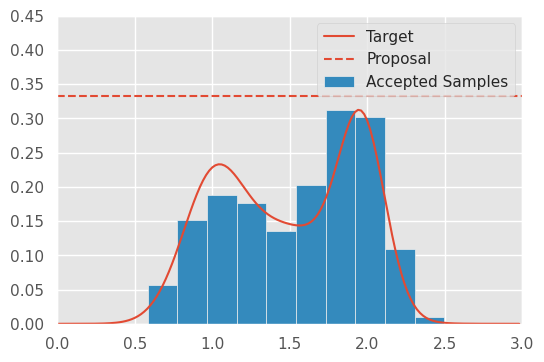

In [14]:
# No TODOs here
# Just run it once you passed the tests above

fig = plt.figure(figsize = (6, 4))
c = 1/15
target_samples = get_1D_samples(1000, c)
density_values =  target_1D_density(COORDINATES)*c
plt.plot(COORDINATES, density_values, label='Target')
plt.axhline(1/3, ls = '--', label = 'Proposal')
n, bins, rects = plt.hist(target_samples, density = True, label="Accepted Samples")
max_height = np.max([r.get_height() for r in rects])
for r in rects:
    r.set_height(r.get_height()*np.max(density_values)/max_height)
plt.legend()
plt.xlim(0,3)
plt.ylim(0,0.45)
plt.show()

#### Computing the acceptance ratio for varying scaling constants c

In [15]:
# No TODOs here
# Just run it and comment in the section below

N = 1000
c_values = [0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
for c in c_values:
    # compute target samples
    target_samples = get_1D_samples(N, c)
    acceptance_percentage = 100*len(target_samples)/N
    print("For c = {:.2f}, the acceptance percentage is {:.1f}%".format(c, acceptance_percentage))

For c = 0.06, the acceptance percentage is 27.6%
For c = 0.05, the acceptance percentage is 23.7%
For c = 0.04, the acceptance percentage is 17.5%
For c = 0.03, the acceptance percentage is 12.8%
For c = 0.02, the acceptance percentage is 9.5%
For c = 0.01, the acceptance percentage is 4.1%


<!-- BEGIN QUESTION -->

#### In the cell below explain why the accepted percentage decreases as $c$ decreases:

Because mathematically, you would always get lower value if you multiply with smaller c. As q(x) and f(x) are 'fixed' and if q(x) gets multipled with smaller c, you're bound to get lower result after dividing with f(x).

<!-- END QUESTION -->

### 1.b Sample from the two-dimensional density $q(x, y)$

In two dimensions Rejection Sampling is nearly identical to the 1-dimension case:

- Find constant $c$, such that $cq(x, y)\leq f(x, y)$ on the support
- At each iteration:
    - Sample $(x_i, y_i) \sim F$
    - Compute the ratio $r = \frac{c(q(x_i, y_i))}{f(x_i, y_i)} \leq 1$
    - Sample $\gamma_i \sim Uniform(0,1)$:
        - `accept` the sample if $\gamma_i \leq r$: add $(x_i, y_i)$ to the list of samples.
        - `reject` the sample otherwise: do nothing

Throughout part 1.b we will consider $(x, y)\sim Uniform(0,3)\times Uniform(0,3)$ as our proposal distribution. Meaning that $f(x, y) = \frac{1}{9}\ \forall x, y\in[0,3]$

Fill in the 2-d ratio calculation:

In [16]:
@np.vectorize
def compute_ratio_2D(proposed_sample_x, proposed_sample_y, c):
    """
    Computes the ratio between the scaled target density and proposal density evaluated at the 
    proposed sample point
    
    Inputs:
        proposed_sample_x : float, x components of the proposed sample point
        proposed_sample_y : float, y components of the proposed sample point
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        ratio : float
    """
    ratio = (c * target_density(proposed_sample_x, proposed_sample_y)) / (1/9)
    assert(ratio <= 1)
    return(ratio)

Use the following cell to convince yourself that your code is correct:

In [17]:
# WRITE YOUR TEST CASES HERE

Now we have all the ingredients for making the 2-d sampler.

In [18]:
# No TODOs here, just run the 2D version of the functions we built in 1.a
def get_2D_samples(N, c): 
    """ 
    Produces samples from target_density
    
    Inputs:
        N : int, number of proposed_samples
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        rejection_samples : ndarray of which contains independent samples from the target
    """
    proposed_samples_x = sample_1D_proposed_distribution(N)
    proposed_samples_y = sample_1D_proposed_distribution(N)
    ratios = compute_ratio_2D(proposed_samples_x, proposed_samples_y, c)
    accept_array = accept_proposal(ratios)
    proposed_samples = np.concatenate((proposed_samples_x.reshape(N,1), proposed_samples_y.reshape(N,1)), axis = 1)
    rejection_samples = proposed_samples[accept_array]
    return(rejection_samples)

In [19]:
grader.check("q1b_i")

q1b_i results: All test cases passed!

From the contour plot we made previously, we can see that $q(x, y=1.2)$ is allways smaller than 7.4. Hence to make it smaller than $f(x) = 1/9$ we need to scale the target density by a factor $c \leq \frac{1}{7.4}\cdot\frac{1}{8} = 0.015$. 

#### Let's use $c=0.015$, compute target samples and plot them on top the contour lines

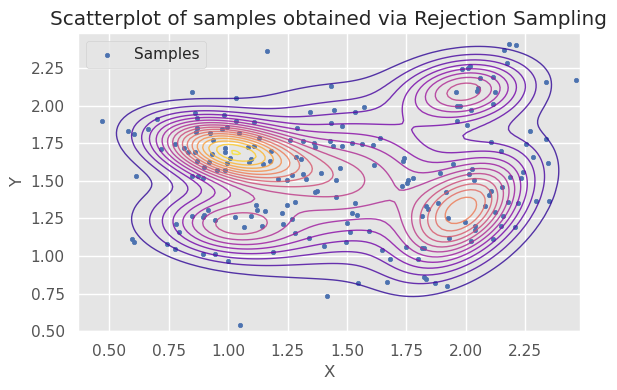

In [20]:
fig = plt.figure(figsize=(6,4))

# Plot the contour plot of the density
cont = plt.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatterplot of samples obtained via Rejection Sampling")

# Add sample points obtained via rejection sampling
c = 1/72
target_samples = get_2D_samples(3000, c)
plt.scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 1, s = 10, label = 'Samples')

plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# No need to modify this
# just run it and comment in the section below

N = 3000
c_values = [0.015, 0.01, 0.005, 0.001]
for c in c_values:
    # compute target samples
    target_samples = get_2D_samples(N, c)
    acceptance_percentage = 100*len(target_samples)/N
    print("For c = {:.3f}, the acceptance percentage is {:.1f}%".format(c, acceptance_percentage))

For c = 0.015, the acceptance percentage is 7.8%
For c = 0.010, the acceptance percentage is 4.9%
For c = 0.005, the acceptance percentage is 2.5%
For c = 0.001, the acceptance percentage is 0.8%


<!-- BEGIN QUESTION -->

#### In the cell below explain why the accepted percentage when sampling from 2D distribution is so much smaller than sampling from the 1D version in 1.a.

Rejection sampling for 1d is already inefficient so doing it in 2d will be much more inefficient leaving many data thrown away. Having this concept in mind, similar to the previous written portion, lower c will result lower acceptance percentage.

<!-- END QUESTION -->

## Question 2. Gibbs Sampling

In this question, we will build a Gibbs sampler and apply it to the same density. First, let's go over the basics of Gibbs Sampling.

Assume we want to sample from an unnormalized target density $q(x, y)$. 

#### Gibbs Sampling proceeds as follows:

- Start at an initial point $(x_0, y_0)$
- For `i` in `number of iterations`:
    - Condition on $y=y_{i-1}$: Sample $x_i \sim q(x| y=y_{i-1})$ 
        - Add $(x_i, y_{i-1})$ to the list of samples
    - Condition on $x=x_{i}$: : Sample $y_i \sim q(y| x=x_{i})$ 
        - Add $(x_i, y_{i})$ to the list of samples
    
In many problems we can sample the univariate distributions directly. In this case we don't know how to sample them directly, but we can use the 1-D rejection sampler that we computed in 1.a.

In the cell below, we wrote helper functions that sample from the conditionals aboves. They are essentially the same function you wrote in 1.a, just slightly modified such that we perform rejection sampling until we get one valid sample.

In [22]:
# No TODOs here:
# Just look at these helper functions and make sure you understand the syntax

def sample_x_cond(fixed_y_val):
    """ 
    Produces one sample from x_i ~ q(x | y=fixed_y_val)
    
    Inputs:
        fixed_y_val : float, current value of y, on which we condition
    
    Outputs:
        x_sample: float, one sample from x_i ~ q(x, y=fixed_y_val)
        num_samples : int, number of tries until we accepted a sample
        
    """
    def conditional_density(x):
        return(target_density(x, fixed_y_val))
    x_sample = None
    num_samples = 0
    c = 0.33/(0.2+max(conditional_density(np.arange(0.5, 2.5, 0.05)))) # <- we are cheating a bit here by 
                                                                       # looking for a tight c value
    while x_sample is None:
        proposed_sample = sample_1D_proposed_distribution(1)
        num_samples += 1
        ratio = conditional_density(proposed_sample)*3*c
        assert(ratio <= 1)
        accept = accept_proposal(ratio)
        if accept:
            x_sample = proposed_sample[0]
    return(x_sample, num_samples)


def sample_y_cond(fixed_x_val):
    """ 
    Produces one sample from y_i ~ q(y | x=fixed_x_val)
    
    Inputs:
        fixed_x_val : float, current value of y, on which we condition
    
    Outputs:
        y_sample: float, one sample from y_i ~ q(y | x=fixed_x_val)
        num_samples : int, number of tries until we accepted a sample
        
    """
    def conditional_density(y):
        return(target_density(fixed_x_val, y))
    y_sample = None
    num_samples = 0
    c = 0.33/(0.2+max(conditional_density(np.arange(0.5, 2.5, 0.05))))
    while y_sample is None:
        proposed_sample = sample_1D_proposed_distribution(1)
        num_samples += 1
        ratio = conditional_density(proposed_sample)*3*c
        assert(ratio <= 1)
        accept = accept_proposal(ratio)
        if accept:
            y_sample = proposed_sample[0]
    return(y_sample, num_samples)

### 2.a: Build a Gibbs sampler using the helper functions above
`Note`: Don't forget that at each iteration the Gibbs sampler adds two samples to the list of samples: $(x_i, y_{i-1})$ and $(x_i, y_{i})$

`Hint`: If you cannot pass the test, try making a simple test case with `N=2` and adding some print statements to your code.

`Hint 2`: In our implementation of gibbs sampling, `num_samples` is not trivially equal to `N`, since sampling $x_i \sim f(x| y=y_{i-1})$ and $y_i \sim f(y| x=x_{i})$ rely on rejection sampling.

In [23]:
def get_2D_Gibbs_samples(N, x_0, y_0):
    """
    Produces N samples from the target density using Gibbs Sampling
    
    Inputs: 
        N : desired number of samples
        x_0, y_0 : floats, the coordinates of the starting point
        
    Outputs:
        gibbs_samples : array of dimension (N, 2) where each row is a sample from the target distribution
                        of the form (x_i, y_i)
        num_samples : total number of samples required
    """
    gibbs_samples = [] # Each entry corresponds to a (x_i, y_i)
    num_samples = 0 # Add the number of samples to this variable, note this is not equal to N since rejection sampling
                    # does not accept every sample
    x_curr = x_0 # Current value of x, initialized to x_0
    y_curr = y_0 # Current value of y, initialized to y_0
    
    for i in range(N//2): # The range is N//2 since we are generating two gibbs samples in one iteration
        new_x = sample_x_cond(y_curr)
        x_curr = new_x[0]
        new_y = sample_y_cond(x_curr)
        gibbs_samples.append([new_x[0], y_curr])
        gibbs_samples.append([x_curr, new_y[0]])
        y_curr = new_y[0]
        num_samples += new_x[1] + new_y[1]

    return(gibbs_samples, num_samples)

In [24]:
grader.check("q2a")

q2a results: All test cases passed!

### 2.b : Path traced by the Gibbs sampler
Run the code below to overlay the path traced by the Gibbs Sampler:

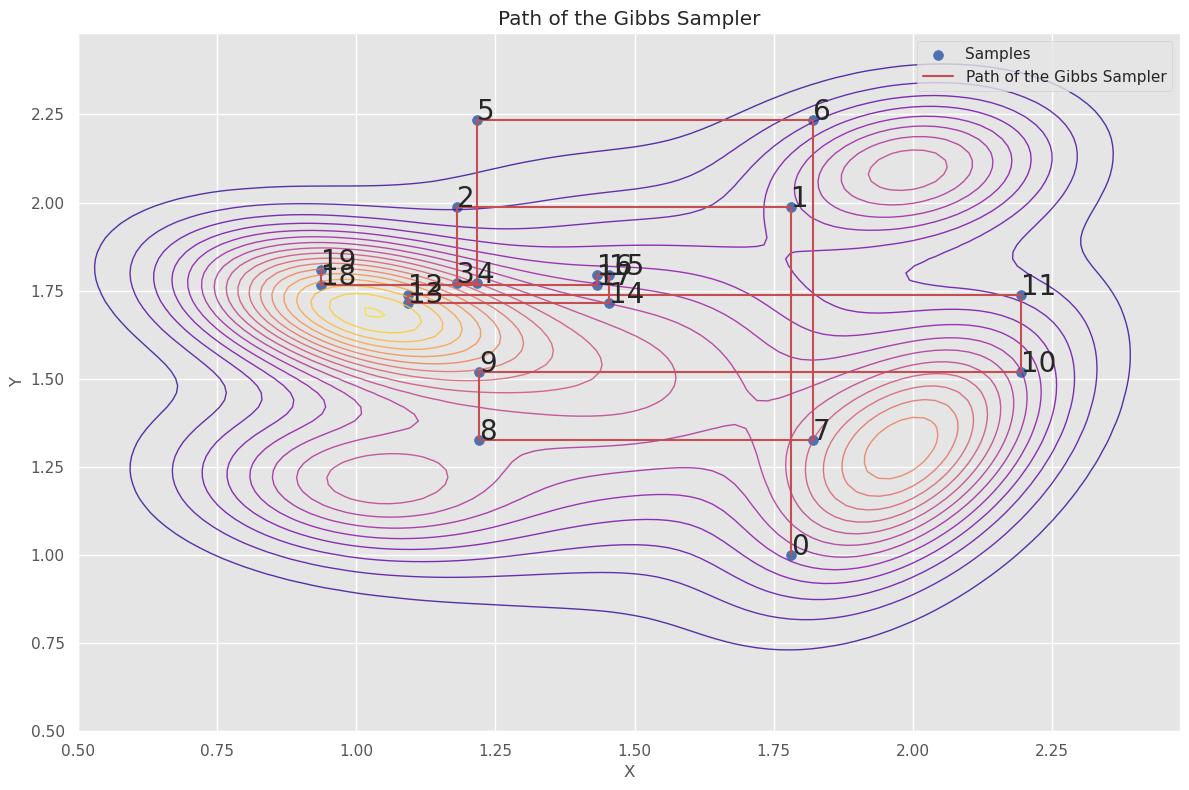

In [25]:
# Do not modify
# Just run this once you've passed the validation tests above
N = 20
target_samples, total_samples = get_2D_Gibbs_samples(N, 1, 1)
target_samples = np.array(target_samples)

fig = plt.figure(figsize=(12,8))

# Plot the contour plot of the density
cont = plt.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Path of the Gibbs Sampler")

# Add sample points obtained via Gibbs sampling
plt.scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 1, s=50, label = 'Samples')
for i in range(N):
    plt.annotate(i, (target_samples[i,0], target_samples[i,1]), fontsize = 20)
plt.plot(target_samples[:,0], target_samples[:,1], c='r', alpha = 1, label = 'Path of the Gibbs Sampler')

plt.legend()
plt.tight_layout()
plt.show()

<!-- BEGIN QUESTION -->

#### Inspect the scatter plot above. Trace the Gibbs sampler path from the initial point (labeled 0) to the final point. What do you notice about the paths between each point? Why do you think that's the case?

You can see that from one point to another moves either horizontally or vertically. This makes sense due to how Gibbs Sampling's algorithm works. We get new x sampling from the existing value of y and vice versa. Each of this procedure either moves horizontally or vertically depending on which one we are sampling in that procedure. 

<!-- END QUESTION -->

### 2.c: 'Efficiency' of Gibbs Sampling
Let's compute 1000 Gibbs samples and compute how many times the rejection sampling subroutine accepted the proposed sample (running this might take a little while):

In [26]:
# No need to modify this
# just run it and comment in the section below
N = 1000
target_samples, total_samples = get_2D_Gibbs_samples(N, 1, 1)
acceptance_rate = N/total_samples*100
print("The acceptance rate for Gibbs Sampling is {:.1f}%".format(acceptance_rate))

The acceptance rate for Gibbs Sampling is 23.5%


<!-- BEGIN QUESTION -->

#### How does Gibbs Sampling compare to vanilla Rejection Sampling from 2b? Is this approach more efficient or less efficient? Why do you think that's the case?

Just from the numbers, you can tell that Gibbs Sampling (GS) is much more efficient than Rejection Sampling. This is because of how their algorithm works. As explained earlier, Rejection Sampling (RS) might be simplest and might be okay to be used for 1d but nothing higher. Unlike RS, GS uses MCMC which allows sampling to move one state from another which leads to being efficient.

<!-- END QUESTION -->

## Question 3. Metropolis Hastings

In this final question, we will build a Metropolis-Hastings sampler. First, let's go over the basics of Metropolis-Hastings Sampling. 

Assume we want to sample from an unnormalized target density $q(x, y)$. 

#### In this question we will consider a Random-Walk Metropolis Hasting Algorithm. The algorithm proceeds as follows:

- Start at an initial point $(x_0, y_0)$
- For `i` in `number of iterations`:
    - Condition on $(x,y)=(x_{i-1},y_{i-1})$. Define proposal distribution $V(x, y| x_{i-1},y_{i-1}):\ \ \begin{bmatrix} x\\ y\end{bmatrix}\sim Normal\left(\begin{bmatrix} x_{i-1}\\ y_{i-1}\end{bmatrix}, \sigma^2 I\right)$
    - Sample $(x',y') \sim V(x, y| x_{i-1},y_{i-1})$ 
    - Compute the ratio $r = \frac{q(x', y')}{q(x_{i-1},y_{i-1})} \frac{V(x_{i-1},y_{i-1}|x', y')}{V(x', y'|x_{i-1},y_{i-1})} =  \frac{q(x', y')}{q(x_{i-1},y_{i-1})}$,
        - If $r \geq  1$: `move` : $(x_i, y_i) = (x', y')$ _(we move to the proposed location)_
        - If $r \leq  1$: `move` with probability $r$, `stay` with probability $1-r$, this is equivalent to:
            - Sample $\gamma_i \sim Uniform (0,1)$:
                 $\cdot \text{ if } \gamma_i \leq r, \textbf{ move: } (x_i, y_i) = (x', y') \\
                 \cdot \text{otherwise,} \textbf{ stay: } (x_i, y_i) = (x_{i-1}, y_{i-1})$
    - Add $(x_i, y_i)$ to the list of samples
    
    
`Note`: in step 3, when computing the ratio $r$ we can cancel out the $q$ terms. We can do that because the proposal distribution is symmetric, meaning that $V(x_{i-1},y_{i-1}|x', y')=V(x', y'|x_{i-1},y_{i-1})$

<!-- BEGIN QUESTION -->

#### Describe in words how the proposal distribution goes from a previous sample to a new proposed sample.

First compute the ratio (r). If r >= 1, we move to the proposed location with probability 1. If r <= 1, we move with probability r and stay with probability 1 - r. This makes sense intuitively because the first case is indicating the location of the new sample is more probable than the current location, hence the state should move. If it is <= 1, the state should move with probability of r because it is not guaranteed. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Describe in words what the ratio `r` represents under a symmetric proposal distribution.

Ratio r representing under a symmetric proposal distribution means that the probability of landing at some point at proposal distribtuion is just as the same as the probability on the prior distribution. Whereas under an asymmetrical distribution is not the same case. Formally, this is called Metropolis whereas under an asymmetric proposal distribution is called Metropolis-Hasting. 

<!-- END QUESTION -->

We implement the MH sampler for you below. Take some time to look at the code.

In [27]:
# No TODOs here: we are providing all the functions to you
# Spend some time examining the code and the algorithm described above

def sample_proposed_normal_distribution(mean, sigma_squared):
    """ 
    Produces a sample from the Uniform(0,3) proposal distribution
    
    Inputs:
        mean : array of length 2, containing the mean of the proposal distributions
        sigma_squared : float, the variance of the proposal distribution
        
    Outputs:
        proposed_sample : array of size 2 which contains a sample (x, y) from the proposal
    """
    
    proposed_sample = multivariate_normal.rvs(mean = mean, cov = sigma_squared)
    return(proposed_sample)

def compute_ratio(proposed_sample, current_sample):
    """
    Computes the ratio r:
    
    Inputs: 
        proposed_sample : array of size 2 which contains sample (x, y) from the proposal
        current_sample : array of size 2 which contains the current (x, y) sample
    """
    ratio = target_density(*proposed_sample)/target_density(*current_sample)
    return(ratio)
    
def move_now(ratio):
    """ 
    Decides to move to the proposed location, or stay at the current location
    
    Inputs: 
        ratio: float
    
    Outputs:
        move: True/False, if True, move to the proposed locatio,
                          if False, stay at the current location
    """
    if ratio >= 1:
        move = True
        return(move)
    else:
        gamma = uniform.rvs(0, 1)
        move = gamma <= ratio
        return(move)

In [28]:
# No TODOs here: Just run the cell to define the function

def get_2D_MH_samples(N, x_0, y_0, sigma_squared):
    """
    Produces N sampled from the target density using Gibbs Sampling
    
    Inputs: 
        N : desired number of samples
        x_0, y_0 : floats, the coordinates of the starting point
        sigma_squared : float, the variance of the proposal distribution
        
    Outputs:
        MH_samples : array of dimension (N, 2) where each row is a sample from the target distribution
                        of the form (x_i, y_i)
        num_moves : number of times the MH algorithm moved to a new point
    """
    MH_samples = []
    current_sample = [x_0, y_0]
    num_moves = 0
    for i in range(N):
        proposed_sample = sample_proposed_normal_distribution(current_sample, sigma_squared)
        ratio = compute_ratio(proposed_sample, current_sample)
        if move_now(ratio):
            current_sample = proposed_sample
            num_moves += 1
        MH_samples.append(current_sample)
    return(MH_samples, num_moves)

#### Run the code below to compute Metropolis Hastings samples for proposal distribution with different variance levels. We overlay the samples on top of the usual contour plots.

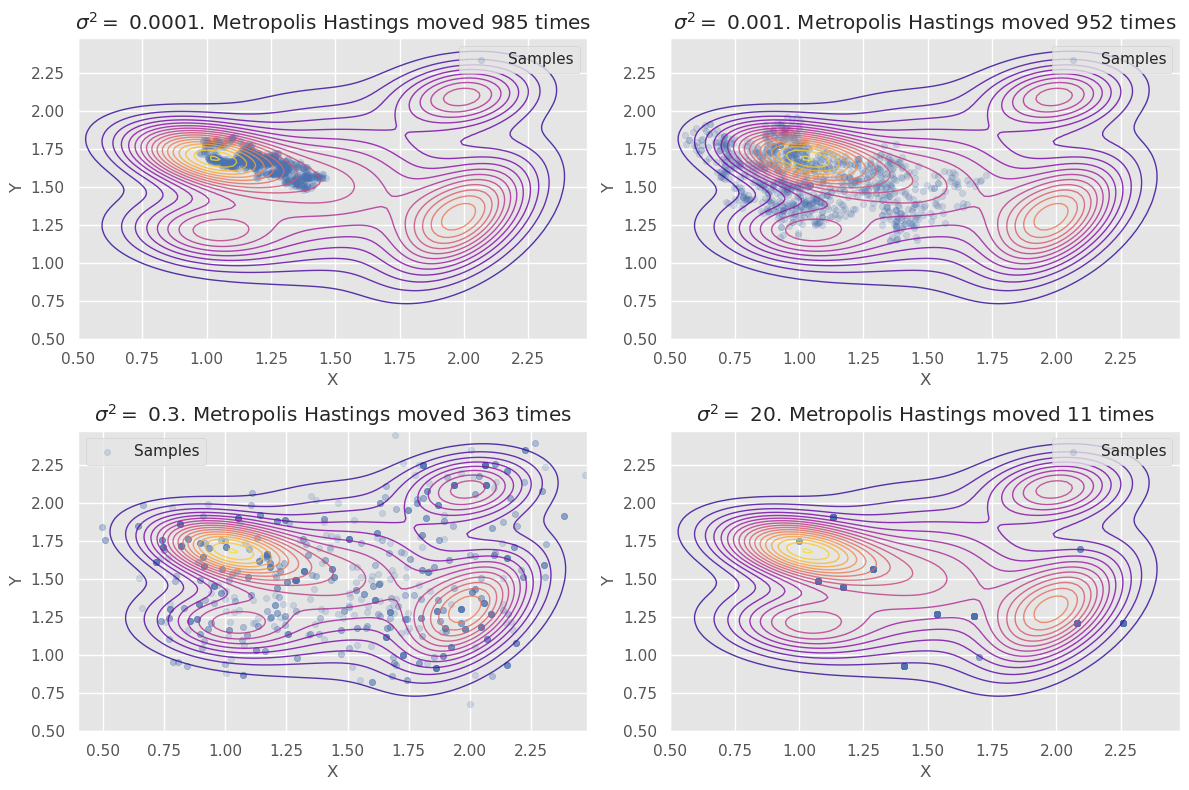

In [29]:
# No TODOs here: Just run the code to create the plots
# Spend some time investigating the code
N = 1000
sigma_squared_values = [0.0001, 0.001, 0.3, 20]
initial_point = [1, 1.75]

fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)

itr = 0
for i in range(2):
    for j in range(2):
        sigma_squared = sigma_squared_values[itr]
        target_samples, num_moves = get_2D_MH_samples(N, *initial_point, sigma_squared)
        # Convert to numpy array
        target_samples = np.array(target_samples)

        # Plot the contour plot of the density
        cont = axs[i,j].contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
        # Add sample points obtained via MH sampling
        axs[i,j].scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 0.2, s=20, label = 'Samples')
        
        axs[i,j].set_xlabel("X")
        axs[i,j].set_ylabel("Y")
        axs[i,j].set_title("$\\sigma^2 = $ {}. Metropolis Hastings moved {} times".format(sigma_squared, num_moves))
        axs[i,j].legend()
        itr += 1
plt.tight_layout()
plt.show()

<!-- BEGIN QUESTION -->

#### `TODO`: Examine the 4 plots above. Each plot contains 1000 Metropolis-Hastongs samples, by considering proposal distributions with different variances. What do you observe? 

- Why do samples stay clustered close to each-other for small value of $\sigma^2$?
- Why does the MH algorithm have so much fewer moves when the value of $\sigma^2$ is large?
- Which value of $\sigma^2$ would you choose out of the above and why?

Above plots show how different level of variance changes the result of M-H.

Top-left plot is due to very low variance. Low variance leads to large amount of movements (almost always accepting to move) but moving very little every time.

Bottom-right plot if due to very high variance. Opposite of the top-left plot, high variance leads to almost always rejecting to move.

With 1000 sample, I will choose bottom-left plot as it looks most similar to the target distribution. But if there were more samples generated, top-right plot does not seem bad either.


<!-- END QUESTION -->



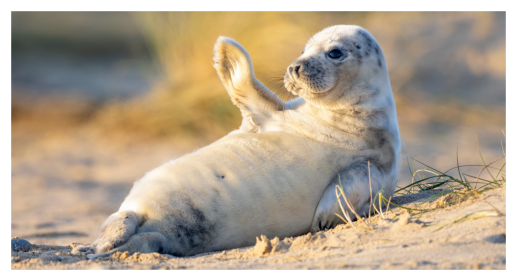

Congrats! You made it to the end of the lab!!!


In [30]:
import matplotlib.image as mpimg
img = mpimg.imread('baby_seal.png')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()
print('Congrats! You made it to the end of the lab!!!')

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [31]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1a_ii results: All test cases passed!

    q1b_i results: All test cases passed!

    q2a results: All test cases passed!
